In [17]:
%pip install seaborn
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from glob import glob
import librosa
import librosa.display
import IPython.display as ipd
from itertools import cycle

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

Note: you may need to restart the kernel to use updated packages.


In [20]:
audio_files = glob('rain.mp3')
print(f"Found {audio_files} audio files.")

Found ['rain.mp3'] audio files.


In [21]:
ipd.Audio(audio_files[0])

In [22]:
y, sr = librosa.load(audio_files[0])

print(f'y: {y[:10]}')
print(f'shape y: {y.shape}')
print(f'sr: {sr}')

y: [ 8.0196184e-19 -1.3492717e-18  1.9847181e-18 -1.2022009e-18
  2.0702097e-18 -2.5368333e-18  2.4875658e-18 -2.7494549e-18
  2.8166013e-18 -2.9756532e-18]
shape y: (1107087,)
sr: 22050


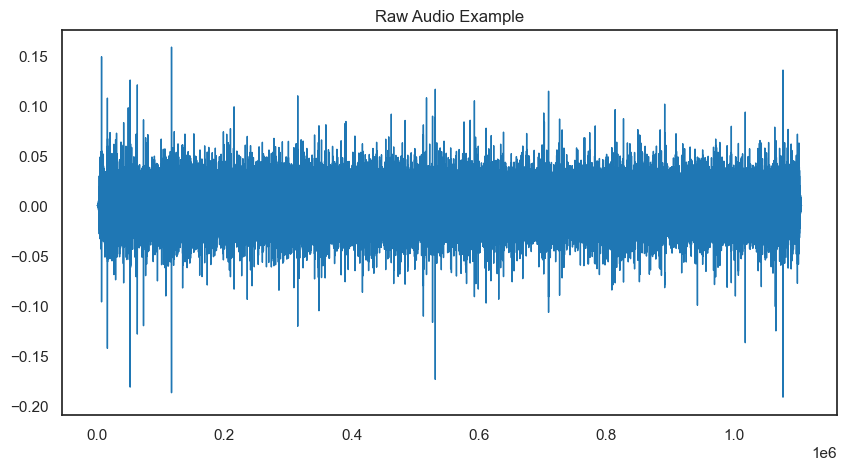

In [23]:
pd.Series(y).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Example',
                 color=color_pal[0])
plt.show()

y_trimmed: [-0.01282017 -0.00866564  0.00936304  0.01914859  0.01227881  0.01084484
  0.00733572 -0.00073205 -0.00646388 -0.02006127]


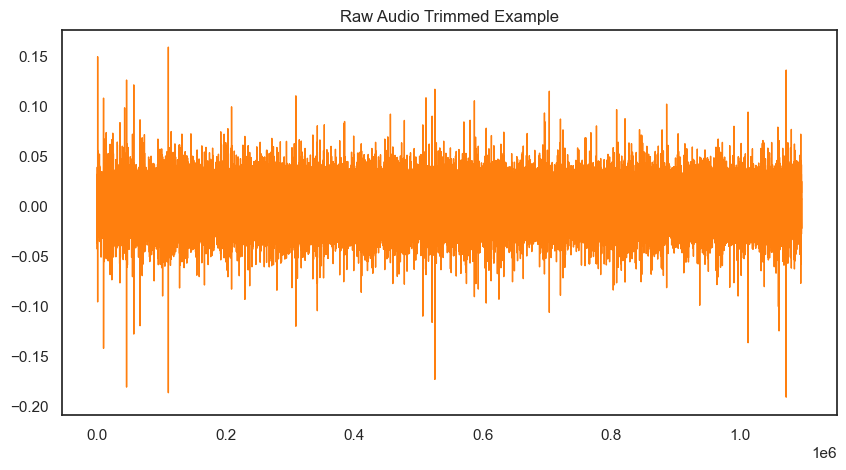

In [24]:
# Trimming leading/lagging silence
y_trimmed, _ = librosa.effects.trim(y, top_db=2)
print(f'y_trimmed: {y_trimmed[:10]}')
ipd.Audio(y_trimmed, rate=sr)
pd.Series(y_trimmed).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Trimmed Example',
                 color=color_pal[1])
plt.show()

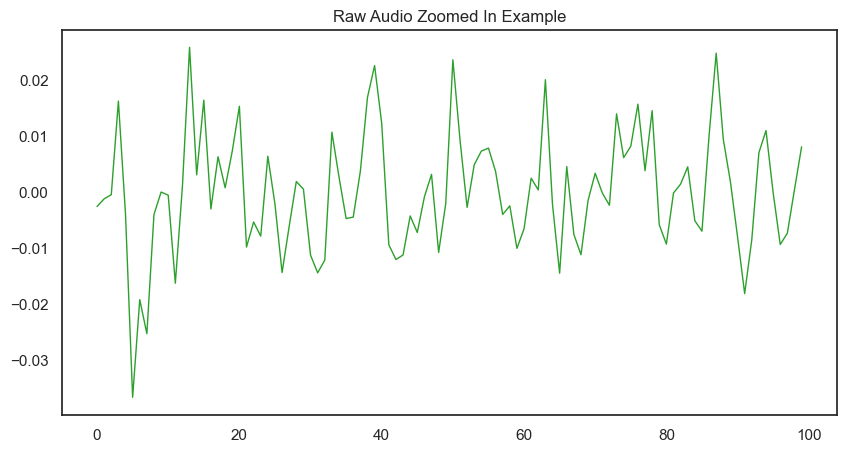

In [25]:
pd.Series(y[30000:30100]).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Zoomed In Example',
                 color=color_pal[2])
plt.show()

In [26]:
ipd.Audio(y[30000:30500], rate=sr)
ipd.display(ipd.Audio(y[30000:120000], rate=sr))

In [27]:
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_db.shape

(1025, 2163)

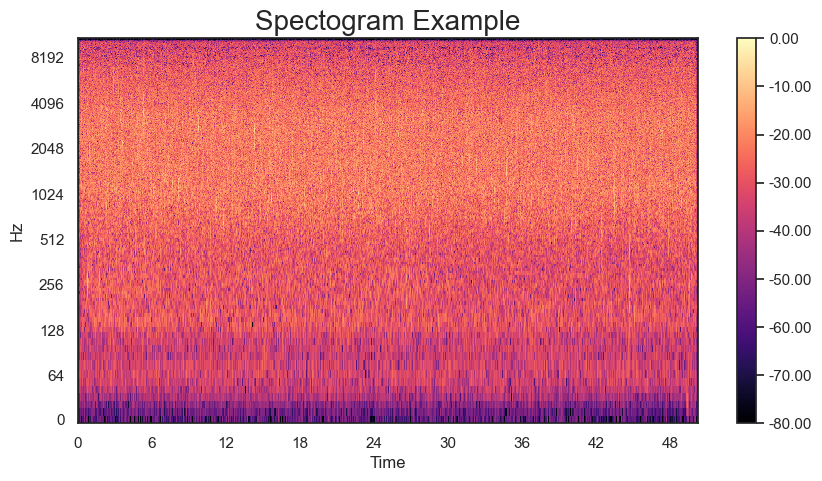

In [28]:
# Plot the transformed audio data
fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(S_db,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

In [ ]:
S = librosa.feature.melspectrogram(y=y,
                                   sr=sr,
                                   n_mels=128 * 2,)
S_db_mel = librosa.amplitude_to_db(S, ref=np.max)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
# Plot the mel spectogram
img = librosa.display.specshow(S_db_mel,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Mel Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

y, sr = librosa.load('rain.mp3', sr=None)

# Estimate the fundamental frequency (pitch)
f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))

# Get only the F0 values where the algorithm is confident a pitch exists
times = librosa.times_like(f0)
f0_voiced = f0[voiced_flag]
times_voiced = times[voiced_flag]

# Plot the pitch track
plt.figure(figsize=(10, 4))
plt.plot(times_voiced, f0_voiced, label='F0', color='cyan', linewidth=3)
plt.title('Pitch (Fundamental Frequency) Track')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.show()


In [ ]:
# =============================================================================
# Binary Audio Classifier: Raining vs. Not Raining
#
# This script trains a model to classify an audio clip as either containing
# the sound of rain or not.
#
# --- HOW TO USE ---
# 1. Create a main folder for your project.
# 2. Inside, create two sub-folders named 'rain' and 'not_rain'.
# 3. Place several audio files (.wav, .mp3) of rain sounds into the 'rain' folder.
# 4. Place several audio files of other sounds (music, speech, dogs, etc.)
#    into the 'not_rain' folder. The more varied, the better.
# 5. Make sure this script is in the main project folder.
# 6. Run the script. It will train the model and test it on one of your files.
#
# You will need to install the necessary libraries:
%pip install tensorflow pandas numpy librosa matplotlib scikit-learn
%pip install resampy
# =============================================================================

import os
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
import resampy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical


In [ ]:

# --- Configuration ---
DATA_DIR = './Dataset'
TARGET_DURATION = 5.0
MAX_PAD_LEN = 216 # Spectrogram length for a 5-second clip at 22050 Hz

def extract_features(file_path):
    """
    Extracts Mel spectrogram features from an audio file.
    It normalizes the audio by truncating it to a fixed duration from the middle.
    """
    print(f"Processing: {os.path.basename(file_path)}")
    try:
        # Load the audio file. librosa automatically normalizes the amplitude.
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
        
        # --- Pre-processing: Truncate audio to a fixed duration ---
        audio_duration = librosa.get_duration(y=audio, sr=sample_rate)
        if audio_duration > TARGET_DURATION:
            # If audio is longer than target, take a clip from the middle
            start = int((audio_duration - TARGET_DURATION) / 2 * sample_rate)
            end = start + int(TARGET_DURATION * sample_rate)
            audio = audio[start:end]
            print(f"  - Original duration: {audio_duration:.2f}s. Truncated to middle {TARGET_DURATION}s.")
        
        # --- Feature Extraction: Mel Spectrogram ---
        melspectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=128)
        
        # Pad or truncate the spectrogram to a fixed length for model consistency
        pad_width = MAX_PAD_LEN - melspectrogram.shape[1]
        if pad_width > 0:
            melspectrogram = np.pad(melspectrogram, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            melspectrogram = melspectrogram[:, :MAX_PAD_LEN]
        
        print(f"  - Final feature shape: {melspectrogram.shape}")
            
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None
    return melspectrogram

def preprocess_dataset():
    """Loads audio files, extracts features, and prepares them for training."""
    features = []
    
    print("\n--- Starting Data Pre-processing ---")
    # Process 'rain' folder
    rain_path = os.path.join(DATA_DIR, 'rain')
    for filename in os.listdir(rain_path):
        filepath = os.path.join(rain_path, filename)
        if filepath.endswith(('.wav', '.mp3')):
            data = extract_features(filepath)
            if data is not None:
                features.append([data, 'rain'])

    # Process 'not_rain' folder
    not_rain_path = os.path.join(DATA_DIR, 'not_rain')
    for filename in os.listdir(not_rain_path):
        filepath = os.path.join(not_rain_path, filename)
        if filepath.endswith(('.wav', '.mp3')):
            data = extract_features(filepath)
            if data is not None:
                features.append([data, 'not_rain'])
    print(f"\nProcessed {0} audio files from 'rain' folder.".format(features))
    
    if not features:
        print("\nCould not find any audio files. Please check your folder structure.")
        return None

    # Convert to a DataFrame for easier handling
    features_df = pd.DataFrame(features, columns=['feature', 'class_label'])
    print(f"\nSuccessfully processed {len(features_df)} audio files.")
    return features_df

def build_and_train_model(features_df):
    """Builds, trains, and evaluates the CNN model."""
    print("\n--- Preparing Data for Model ---")
    # Convert features and labels to NumPy arrays
    X = np.array(features_df['feature'].tolist())
    y = np.array(features_df['class_label'].tolist())

    # Encode the string labels to integers (0 for 'not_rain', 1 for 'rain')
    le = LabelEncoder()
    y_encoded = to_categorical(le.fit_transform(y))
    print(f"Class labels encoded: {le.classes_}")

    # Split the dataset into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

    # Reshape the data for the CNN input layer
    num_rows, num_columns = X[0].shape
    num_channels = 1
    x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
    x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)
    
    num_labels = y_encoded.shape[1]
    
    print(f"Training data shape: {x_train.shape}")
    print(f"Testing data shape: {x_test.shape}")

    # --- Build the CNN Model ---
    print("\n--- Building CNN Model ---")
    model = Sequential([
        Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(num_rows, num_columns, num_channels)),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        
        Dense(num_labels, activation='softmax') # Softmax for classification
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    # --- Train the Model ---
    print("\n--- Training the model... ---")
    history = model.fit(x_train, y_train, batch_size=32, epochs=30, validation_data=(x_test, y_test), verbose=1)

    # --- Evaluate the Model ---
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    print(f"\n--- Model Evaluation ---")
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    
    return model, le

def predict_on_file(model, label_encoder, file_path):
    """Makes a prediction on a single audio file."""
    print(f"\n--- Making a prediction on: {os.path.basename(file_path)} ---")
    
    # Extract features from the new file
    prediction_feature = extract_features(file_path)
    if prediction_feature is None:
        return
        
    # Reshape for the model
    prediction_feature = prediction_feature.reshape(1, prediction_feature.shape[0], prediction_feature.shape[1], 1)

    # Get the prediction
    prediction_vector = model.predict(prediction_feature)
    predicted_class_index = np.argmax(prediction_vector)
    
    # Convert the index back to the original label
    predicted_class_name = label_encoder.inverse_transform([predicted_class_index])[0]

    print(f"The model predicts this sound is: '{predicted_class_name}'")
    print(f"Confidence: {np.max(prediction_vector) * 100:.2f}%")


In [ ]:
# --- Main Execution ---
if __name__ == '__main__':
    # 1. Prepare the data
    features_df = preprocess_dataset()
    
    if features_df is not None:
        # 2. Build and train the model
        model, label_encoder = build_and_train_model(features_df)
        
        # 3. Test the model on a sample file
        #    (You can change this to any audio file you want to test)
        rain_files = [os.path.join('Dataset/rain', f) for f in os.listdir('Dataset/rain') if f.endswith(('.wav', '.mp3'))]
        not_rain_files = [os.path.join('Dataset/not_rain', f) for f in os.listdir('Dataset/not_rain') if f.endswith(('.wav', '.mp3'))]

        if rain_files:
            predict_on_file(model, label_encoder, rain_files[0])
        if not_rain_files:
            predict_on_file(model, label_encoder, not_rain_files[0])

In [ ]:
predict_on_file(model, label_encoder, 'Dataset/rain/test-rain.mp3')  # Change to your test file path
predict_on_file(model, label_encoder, 'Dataset/not_rain/test2.wav')  # Change to your test file path